<a href="https://colab.research.google.com/github/mifm/examples/blob/master/Layout_and_cables_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## INSTALL ALL REQUIRED PACKAGES
%%capture
import importlib
if not importlib.util.find_spec("py_wake"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git
if not importlib.util.find_spec("topfarm"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git
if not importlib.util.find_spec("ed_win"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git#egg=ed_win[interarray]

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from topfarm import TopFarmProblem, TopFarmGroup
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.plotting import XYPlotComp
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

from py_wake.deficit_models.gaussian import BastankhahGaussian
from py_wake.utils.gradients import autograd
from py_wake.validation.lillgrund import wt_x, wt_y, LillgrundSite, ct_curve, power_curve
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

from ed_win.wind_farm_network import WindFarmNetwork

Solving with heuristic(cpew)

Solving with heuristic(cpew)

INFO: checking out_of_order


/usr/local/lib/python3.10/dist-packages/py_wake/deficit_models/gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')
INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


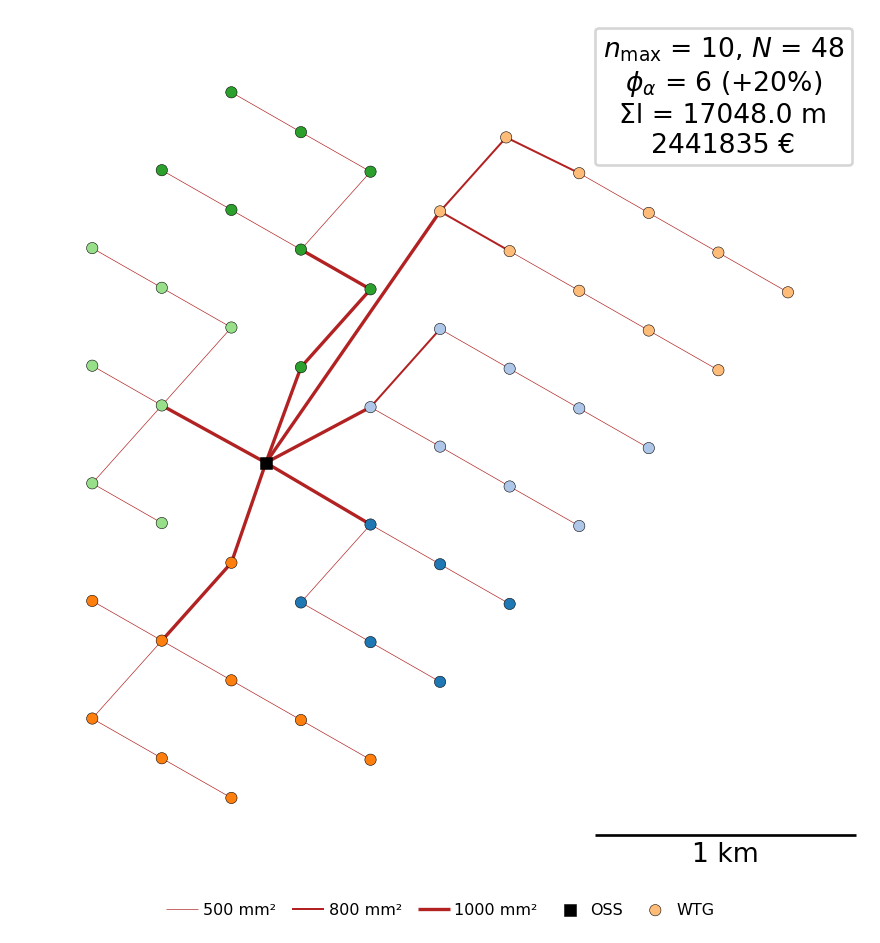

In [3]:
wind_turbines = WindTurbine('SWT2p3_93_65', 92.6, 65, PowerCtTabular(ct_curve[:,0],power_curve[:,1], 'kW', ct_curve[:,1]))
substation_init = [359470, 6153890]
n_wt = len(wt_x)
site = LillgrundSite()
turbines_pos=np.asarray([wt_x, wt_y]).T
substations_pos = np.asarray([[substation_init[0]], [substation_init[1]]]).T
cables = np.array([[500, 3, 100], [800, 5, 150], [1000, 10, 250]])
wfn = WindFarmNetwork(turbines_pos=turbines_pos, substations_pos=substations_pos, cables=cables)
G = wfn.optimize(turbines_pos)
cable_cost_ref = G.size(weight="cost")  # euro
cable_length_ref = G.size(weight="length")  # m
cost_per_length_ref = cable_cost_ref / cable_length_ref # euro / m

G.plot()

def cable_func(x, y, x_substation, y_substation, **kwargs):
    G = wfn.optimize(turbines_pos= np.asarray([x, y]).T, substations_pos=np.asarray([[float(x_substation)], [float(y_substation)]]).T)
    return G.size(weight="cost"), {'cabling_length': G.size(weight="length")}
res = cable_func(wt_x, wt_y, substation_init[0], substation_init[1])
cable_component = CostModelComponent(input_keys=[('x', wt_x),('y', wt_y), ('x_substation', substation_init[0]), ('y_substation', substation_init[1])],
                                     n_wt=n_wt,
                                     cost_function=cable_func,
                                     objective=False,
                                     output_keys=[('cabling_cost', 100000)],
                                     additional_output=[('cabling_length', 10000)])
max_cable_length = 16500
wf_model = BastankhahGaussian(site, wind_turbines)
constraint_comp = XYBoundaryConstraint(np.asarray([wt_x, wt_y]).T)
aep_comp = PyWakeAEPCostModelComponent(windFarmModel=wf_model,
                                        n_wt=n_wt,
                                        grad_method=autograd)
cost_comp = TopFarmGroup([cable_component, aep_comp])
problem = TopFarmProblem(design_vars={'x': (wt_x, np.min(wt_x), np.max(wt_x)), 'y': wt_y, 'x_substation': substation_init[0], 'y_substation': substation_init[1],},
                        constraints=[constraint_comp, SpacingConstraint(min_spacing=wind_turbines.diameter() * 2),
                                      ('cabling_length', {'upper': max_cable_length})],
                        cost_comp=cost_comp,
                        driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=10),
                        plot_comp=XYPlotComp())

In [4]:
%%capture
cost, state, recorder = problem.optimize(disp=True)

INFO:check_config:checking out_of_order
INFO:check_config:checking system
INFO:check_config:checking solvers
INFO:check_config:checking dup_inputs
INFO:check_config:checking missing_recorders
INFO:check_config:checking unserializable_options
INFO:check_config:checking comp_has_no_outputs
INFO:check_config:checking auto_ivc_warnings


<ipython-input-5-b38f900964d6>:17: UserWarning: The figure layout has changed to tight
  fig.tight_layout()  # otherwise the right y-label is slightly clipped


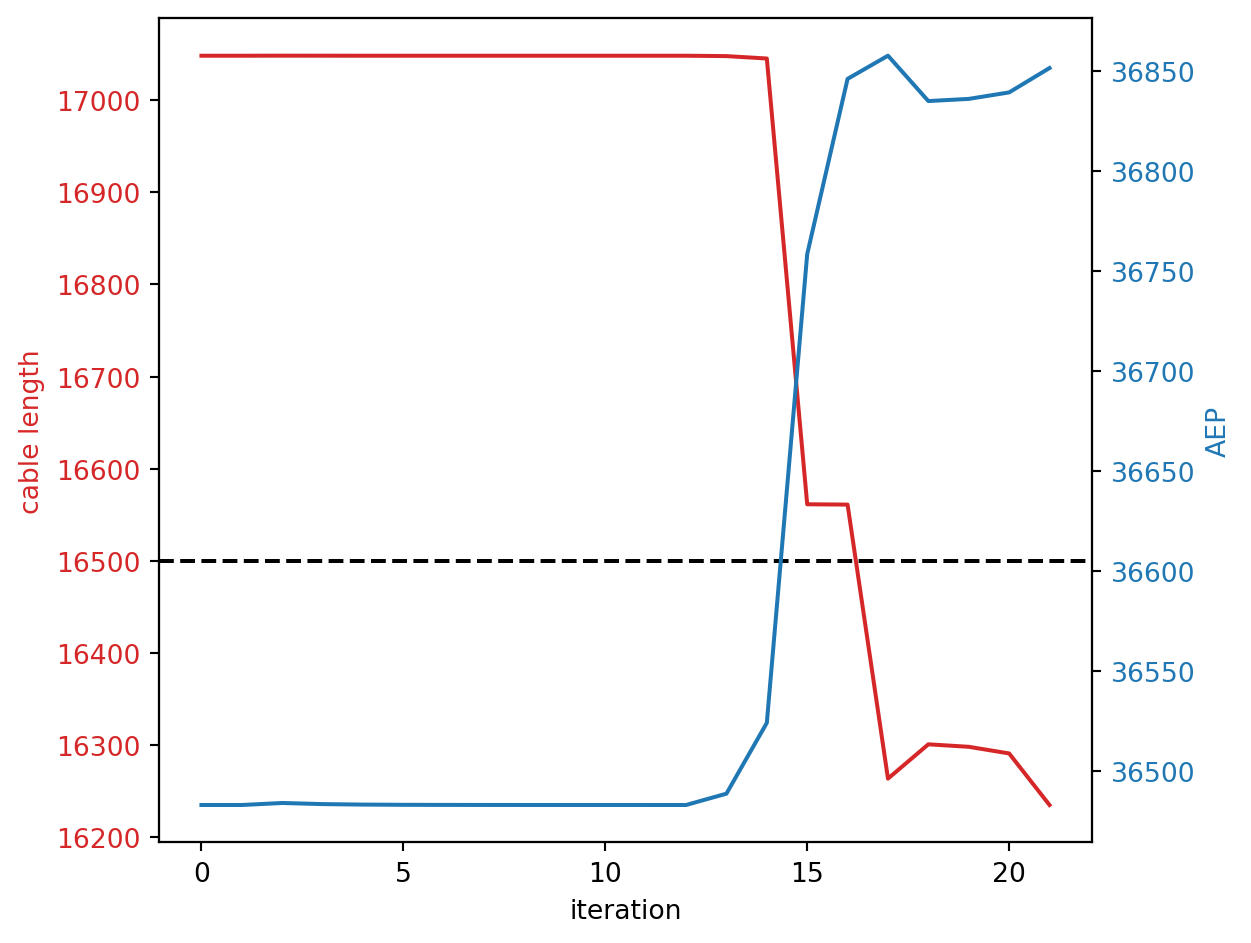

In [5]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('iteration')
ax1.set_ylabel('cable length', color=color)
ax1.plot(recorder['cabling_length'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.axhline(y=max_cable_length, xmin=0, xmax=recorder['cabling_length'].size, color='black', linestyle='--')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('AEP', color=color)  # we already handled the x-label with ax1
ax2.plot(recorder['AEP'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Solving with heuristic(cpew)



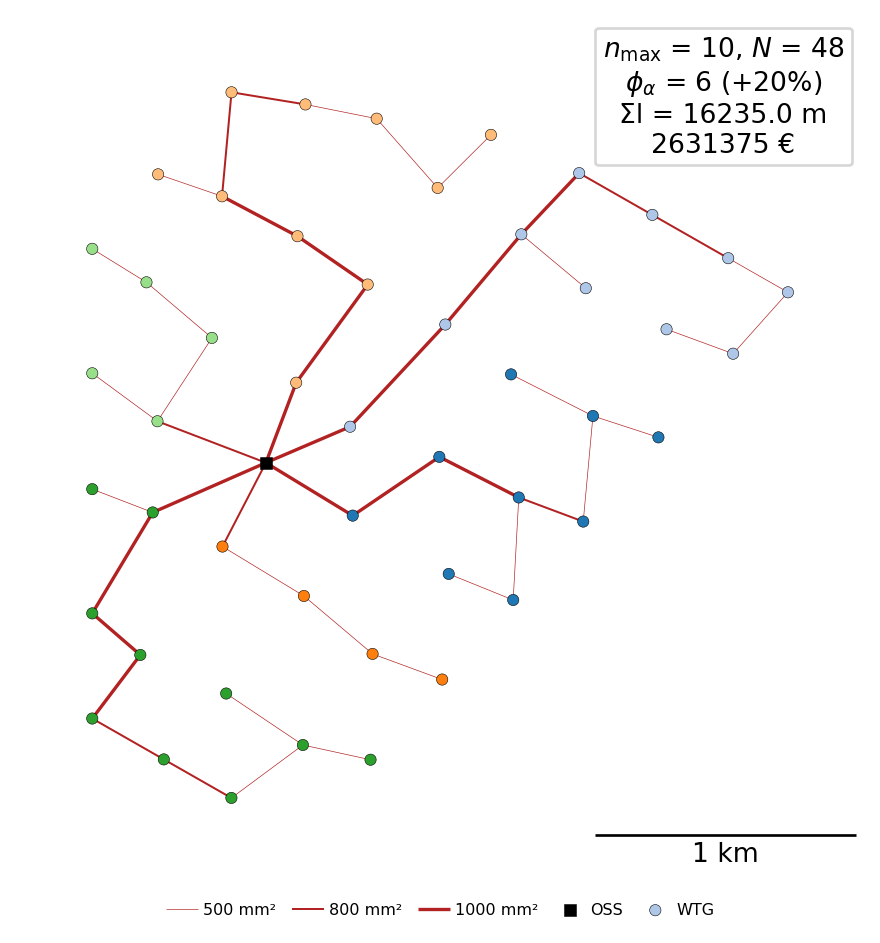

In [6]:
x_opt = recorder['x'][-1]
y_opt = recorder['y'][-1]
G = wfn.optimize(np.asarray([recorder['x'][-1], recorder['y'][-1]]).T,
                 substations_pos=np.asarray([[float(recorder['x_substation'][-1])], [float(recorder['y_substation'][-1])]]).T,
                 )
G.plot()
aep_no_wake = wf_model(x_opt, y_opt).aep(with_wake_loss=False).sum()
aep = wf_model(x_opt, y_opt).aep(with_wake_loss=True).sum()
wl = (aep_no_wake - aep) / aep_no_wake * 100


In [7]:
print(f'Wake loss: {wl:.2f}%')

Wake loss: 20.10%
